In [1]:
# read nc output from WAOM 10km run
import venv

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

#import iris
#import iris.iterate
#import iris.coords
#import iris.plot as iplt
import gsw

In [8]:
# test of the depth-integrated vert. diffusion x surface flux

ds = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_21yr/ocean_avg_0006.nc')
shflx = ds.variables["shflux"]
ssflx = ds.variables["ssflux"]
ice_draft = ds.variables["zice"]

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w

dd = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_21yr/ocean_dia_0006.nc')
temp_vdiff = dd.variables["temp_vdiff"]
salt_vdiff = dd.variables["salt_vdiff"]


In [3]:
print(z_w)

<xarray.DataArray (ocean_time: 6, eta_rho: 560, xi_rho: 630, s_w: 32)>
array([[[[-4.04967578e+03, -4.03689267e+03, -4.01221006e+03, ...,
          -2.09994425e+01, -9.05130155e+00, -2.81474665e-02],
         [-4.27402539e+03, -4.26091487e+03, -4.23520718e+03, ...,
          -2.13848503e+01, -9.15825830e+00, -2.81474665e-02],
         [-4.38367139e+03, -4.37040167e+03, -4.34419376e+03, ...,
          -2.15820331e+01, -9.22017396e+00, -3.86220217e-02],
         ...,
         [-3.12949805e+03, -3.11809037e+03, -3.09764291e+03, ...,
          -1.97995380e+01, -9.02617259e+00, -4.74855006e-01],
         [-3.06281030e+03, -3.05150484e+03, -3.03136648e+03, ...,
          -1.96727314e+01, -8.98706562e+00, -4.72594440e-01],
         [-3.20793237e+03, -3.19640503e+03, -3.17559450e+03, ...,
          -1.99426319e+01, -9.06667510e+00, -4.72594440e-01]],

        [[-4.48970361e+03, -4.47628033e+03, -4.44958896e+03, ...,
          -2.17513079e+01, -9.25902953e+00, -2.81474665e-02],
         [-4.3558

In [4]:

dz = np.empty((6,560,630,31))
dz_inv = np.empty((6,560,630,31))

for tt in np.arange(0,6):
    z_w_sorted = -1*z_w[tt,:,:,::-1]
    dz_inv[tt,:,:,:] = np.diff(z_w_sorted,axis=2)
    dz[tt,:,:,:] = dz_inv[tt,:,:,::-1]
    
dz_trsp = dz.transpose(0,3,1,2)

print(dz_trsp.shape)  

(6, 31, 560, 630)


In [7]:
print(dz_inv.shape)

(6, 560, 630, 31)


In [12]:
temp_vdiff_full_vint = np.empty(shflx[:,:,:].shape)
salt_vdiff_full_vint = np.empty(shflx[:,:,:].shape)

for mm in np.arange(0,6):
        # for vertically-integrated vars: calculate var*dz_trsp
        # Diffusion
    temp_vdiff_full_dz_trsp = temp_vdiff[mm,:,:,:]*dz_trsp[mm,:,:,:]
    salt_vdiff_full_dz_trsp = salt_vdiff[mm,:,:,:]*dz_trsp[mm,:,:,:]
            # sum in the vertical
    temp_vdiff_full_vint[mm,:,:] = np.nansum(temp_vdiff_full_dz_trsp, axis=0)
    salt_vdiff_full_vint[mm,:,:] = np.nansum(salt_vdiff_full_dz_trsp, axis=0)
    print(temp_vdiff_full_dz_trsp.shape)

    del temp_vdiff_full_dz_trsp, salt_vdiff_full_dz_trsp

(31, 560, 630)
(31, 560, 630)
(31, 560, 630)
(31, 560, 630)
(31, 560, 630)
(31, 560, 630)


In [20]:

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))

print(mask_zice.shape)

(560, 630)


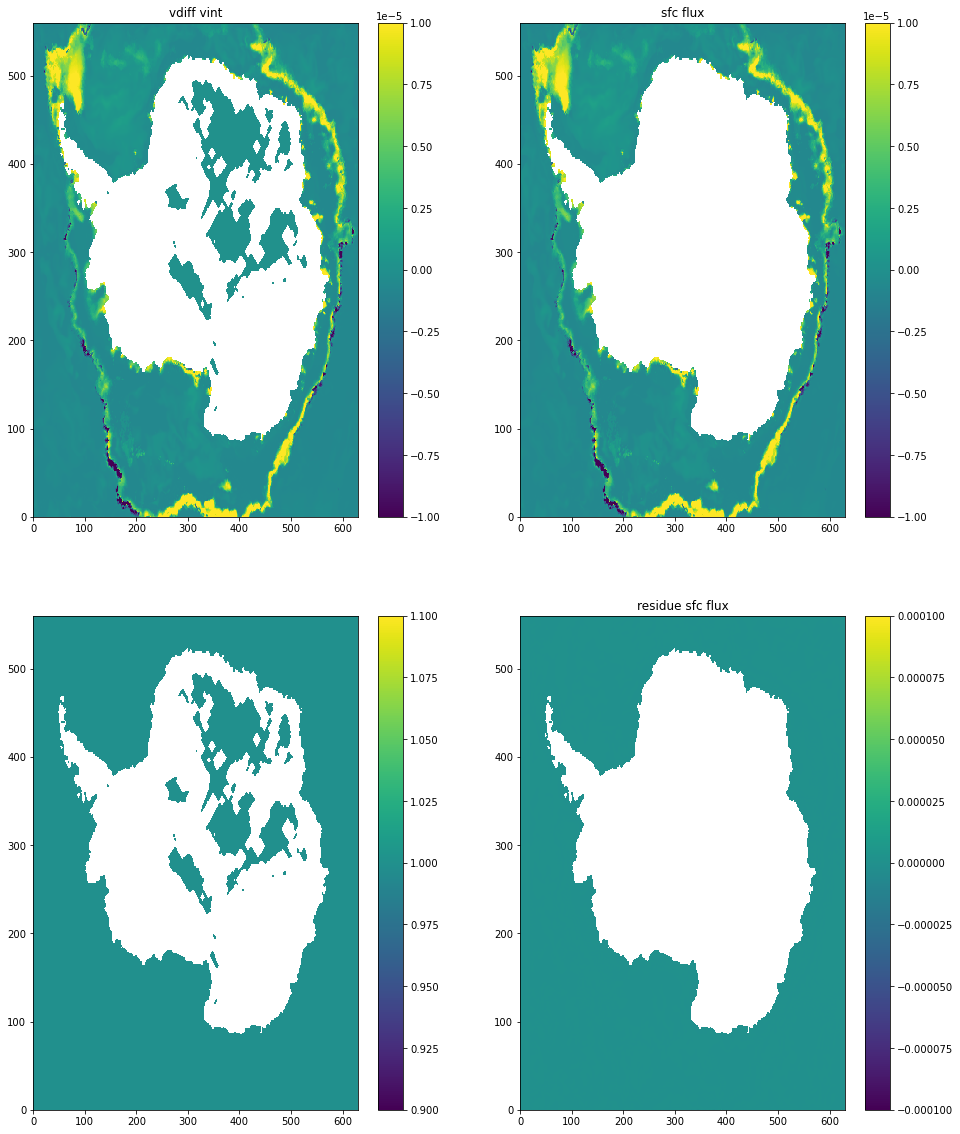

In [25]:

fig = plt.figure(figsize=(16,20))
ax1 = fig.add_subplot(221)
plt.title('vdiff vint')
cy=plt.pcolor(salt_vdiff_full_vint[0,:,:]*mask_zice)
plt.colorbar(cy)
plt.clim(-.00001,.00001)
ax2 = fig.add_subplot(222)
plt.title('sfc flux')
cy=plt.pcolor(ssflx[0,:,:]*mask_zice)
plt.colorbar(cy)
plt.clim(-.00001,.00001)
ax4 = fig.add_subplot(224)
sfc_res = ssflx[0,:,:] - salt_vdiff_full_vint[0,:,:]
plt.title('residue sfc flux')
cy=plt.pcolor(sfc_res*mask_zice)
plt.colorbar(cy)
plt.clim(-.0001,.0001)
ax3 = fig.add_subplot(223)
cy=plt.pcolor(mask_zice)
plt.colorbar(cy)

fig_path = '/users/boeiradi/COLD_project/postprocessing/figs/WMT/'
name_fig="waom10extend_shflim_S_0.25Q_salt_budget_mm6-t1_full_vint.png"
plt.savefig(fig_path + name_fig, dpi=300)



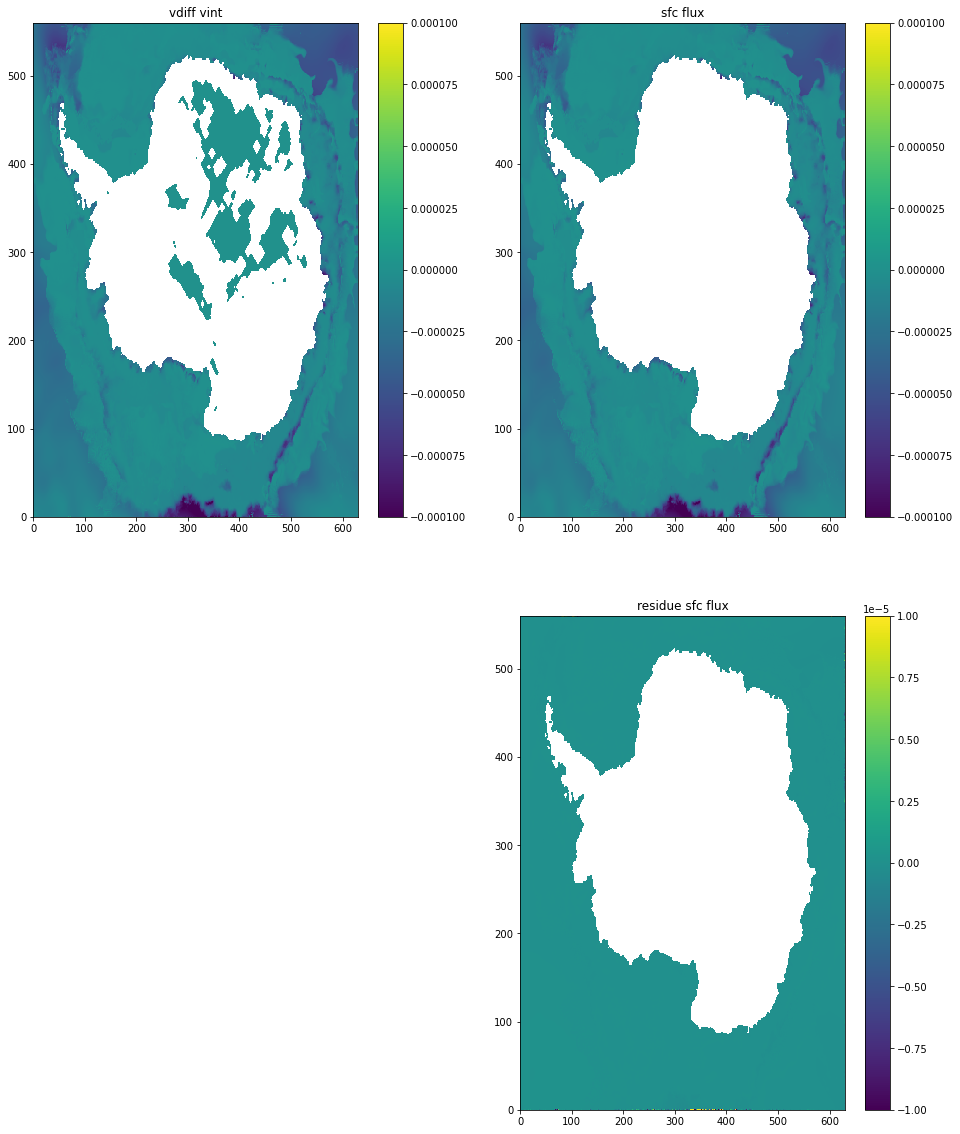

In [27]:
rho0 = 1025 #1000
Cp = 3985

fig = plt.figure(figsize=(16,20))
ax1 = fig.add_subplot(221)
plt.title('vdiff vint')
cy=plt.pcolor(temp_vdiff_full_vint[0,:,:]*mask_zice)
plt.colorbar(cy)
plt.clim(-.0001,.0001)
ax2 = fig.add_subplot(222)
plt.title('sfc flux')
cy=plt.pcolor(np.divide(shflx[0,:,:], rho0*Cp)*mask_zice)
plt.colorbar(cy)
plt.clim(-.0001,.0001)
ax4 = fig.add_subplot(224)
sfc_res = np.divide(shflx[0,:,:],rho0*Cp) - temp_vdiff_full_vint[0,:,:]
plt.title('residue sfc flux')
cy=plt.pcolor(sfc_res*mask_zice)
plt.colorbar(cy)
plt.clim(-.00001,.00001)


name_fig="waom10extend_shflim_S_0.25Q_heat_budget_mm6-t1_full_vint.png"
plt.savefig(fig_path + name_fig, dpi=300)

